In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from sklearn.feature_selection import mutual_info_regression
%matplotlib inline

In [122]:
#hide_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

In [166]:
df = pd.read_csv('data/CA-Data/ca.csv')
df.head()    

DATE  STATUS  QLANG  DEM_GENDER  DEM_AGE  DEM_ABOR  \
0  2017-09-28 18:13:25       3      1           1       18         0   
1  2017-10-18 18:46:34       3      1           1       18         0   
2  2017-09-29 06:58:50       3      1           1       24         0   
3  2017-10-03 17:58:19       3      1           1       16         0   
4  2017-10-25 21:09:49       3      1           1       21         0   

   DEM_ABOR_TYPE  DEM_STDNT  DEM_VET  DEM_HEALTH  ...  FENT_NMU_NTY  \
0            NaN          0        0           0  ...             0   
1            NaN          1        0           0  ...             0   
2            NaN          0        0           0  ...             0   
3            NaN          1        0           0  ...             0   
4            NaN          1        0           0  ...             0   

   HYD_NMU_NTY HYDM_NMU_NTY  METH_NMU_NTY  MORPH_NMU_NTY  OXY_NMU_NTY  \
0            0            0             0              0            0   
1            0            0             0              0            0   
2            0            0             0              0            0   
3            0            0             0              0            0   
4            0            0             0              0            0   

   OXYM_NMU_NTY  SUF_NMU_NTY  TAP_NMU_NTY  TRAM_NMU_NTY  
0             0            0            0             0  
1             0            0            0             0  
2             0            0            0             0  
3             0            0            0             0  
4             0            0            0             0  

[5 rows x 185 columns]

In [30]:
#hide_input
print("df.shape: " + str(df.shape))

df.shape: (10007, 185)


## Data cleaning

In [4]:
#hide_input
has_nulls = set(df.columns[df.isnull().sum()!=0])
print("There are "+str(len(has_nulls))+" many cols with at least one null value")
print(has_nulls)

There are 41 many cols with at least one null value
{'HYD_NMU', 'TAP_NMU', 'PAIN_CHRONIC_RX', 'HEALTH_SETTING_PRIV', 'HEALTH_SETTING_HOS', 'DEM_PREGMNTH', 'COD_NMU', 'MORPH_NMU', 'OPIOID_DEP_METH', 'BENZ_NMU', 'PAIN_CHRONIC_DOC', 'OPIOID_DEP_BUP', 'HELP_SUB_USE_OTH', 'HEALTH_SETTING_OUT', 'HYDM_NMU', 'PAIN_ACUTE_RX', 'HEALTH_SETTING_OTH', 'HEALTH_SETTING_PRE', 'FENT_NMU', 'HEALTH_SETTING_HOME', 'HELP_SUB_USE_PREDRGS', 'HPC_SELL', 'METH_NMU', 'PAIN_ACUTE_DOC', 'TRAM_NMU', 'COTC_NMU', 'OPIOID_DEP_NO', 'DEM_ABOR_TYPE', 'BUP_NMU', 'OXYM_NMU', 'HELP_SUB_USE_ALC', 'OPIOID_DEP_HER', 'HEALTH_ROLE', 'SUF_NMU', 'DEM_PREG', 'THC_NMU', 'OPIOID_DEP_OTH', 'HPC_USE', 'HEALTH_RX', 'OXY_NMU', 'STIM_NMU'}


feature with most nans: DEM_PREGMNTH with 9928


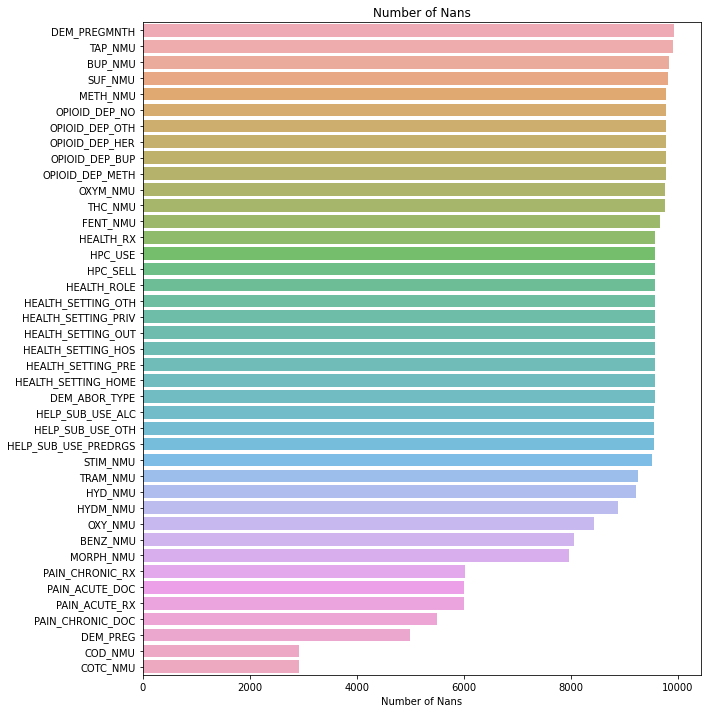

In [142]:
#hide_input
nan_count = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)
print("feature with most nans: DEM_PREGMNTH with " + str(nan_count[0]))
fig, axs = plt.subplots(figsize=(10, 12))
sns.barplot(y = nan_count.index, 
            x = nan_count.values, 
            alpha = 0.8
           )
plt.title('Number of Nans')
plt.xlabel('Number of Nans')
plt.show()

### Cleaning binary and categorical variables

In [79]:
binary_cols = [col for col in df if np.isin(df[col].dropna().unique(), [0,1]).all()]
len(binary_cols)

128

## Question one: Is DRSHOP_NMU a good response variable?<br>
(62. Have you ever attempted to get a prescription from a physician for a medication that you did not need and intended to misuse?) <br>
How does this question relate to following similar questions? <br> (67. Have you used drugs other than those required for medical reasons?) and <br>(63. Have you ever attempted to get a prescription from a physician for a medication that you did not need and intended to sell? )

Percentage of admit guilty DRSHOP_NMU:  0.01299090636554412
Percentage of admit guilty DRSHOP_NMU:  0.01648845807934446
Percentage of admit guilty DAST_1:  0.19926051763765365


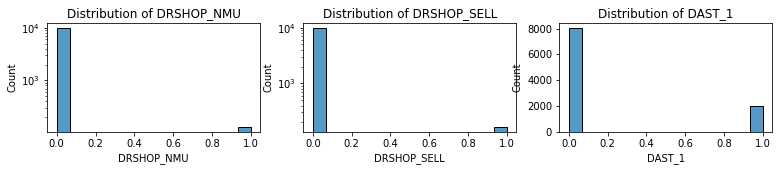

In [77]:
#hide_input
# Is DRSHOP_NMU a good response variable?
print("Percentage of admit guilty DRSHOP_NMU:  "+str(df.DRSHOP_NMU.mean()))
print("Percentage of admit guilty DRSHOP_SELL:  "+str(df.DRSHOP_SELL.mean()))
print("Percentage of admit guilty DAST_1:  "+str(df.DAST_1.mean()))
fig, ax = plt.subplots(1,3, figsize=(13,2))
fig.axes[0].set_title("Distribution of DRSHOP_NMU")
fig.axes[1].set_title("Distribution of DRSHOP_SELL")
fig.axes[2].set_title("Distribution of DAST_1")
drshop_nmu_dist = sns.histplot(df, x="DRSHOP_NMU", ax=ax[0]).set_yscale("log")
drshop_sell_dist = sns.histplot(df, x="DRSHOP_SELL", ax=ax[1]).set_yscale("log")
dast_1_dist = sns.histplot(df, x="DAST_1", ax=ax[2])

1. About 1.3%(130) of participants admitted to attempting to abuse presubscribed drug to misusage. <br>
2. About 1.65%(165) of participants admitted to attempting to misuse presubscribed drug by selling.
<br>
3. About 19.93%(1994) of participants admitted to using drugs other than medical reasons. 

## Question two: Are people lying about misuse?

In [118]:
print("Percentage of Q.64:  "+str(df.HPC_USE.mean()))
print("Percentage of Q.65:  "+str(df.HPC_SELL.mean()))

Percentage of Q.64:  0.12705882352941175
Percentage of Q.65:  0.04470588235294118


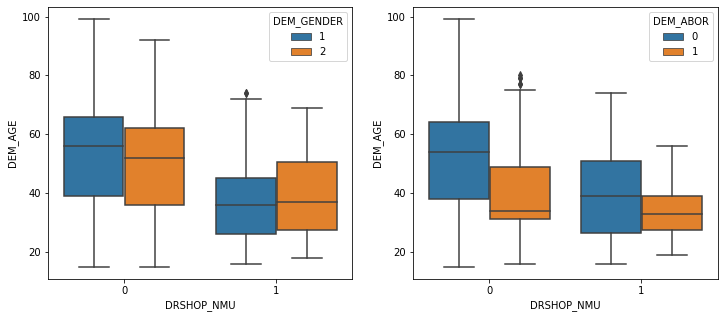

In [85]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
box1 = sns.boxplot(x="DRSHOP_NMU", y="DEM_AGE", hue="DEM_GENDER", data=df, ax=ax[0])
box2 = sns.boxplot(x="DRSHOP_NMU", y="DEM_AGE", hue="DEM_ABOR", data=df, ax=ax[1])

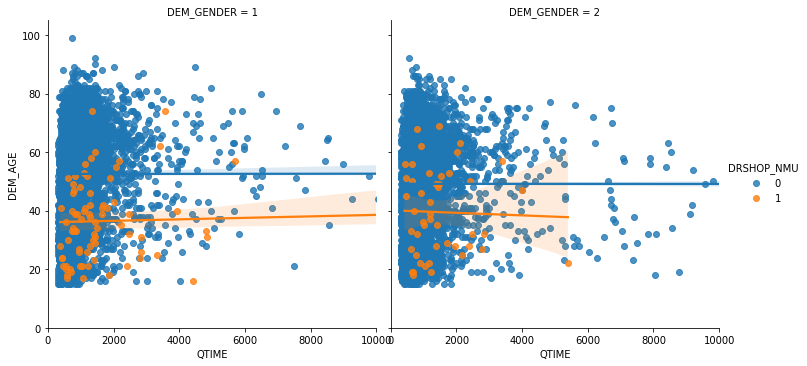

In [117]:
lm1 = sns.lmplot(x="QTIME", y="DEM_AGE", hue="DRSHOP_NMU", col="DEM_GENDER", data=df).set(xlim=(0,10000),ylim=(0,105))

Looks like it was a pretty short survey. Minimum completion time was about 5min and most surveys took around that time to 35 minutes. Some people took literally few days to complete (maximum was about 12 days)

## Data wrangling for prediction

In [157]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [158]:
## columns we don't need
cols_to_remove = ['DATE', 'QTIME', 'START_DATE', 'STATUS', 'VMOBILEDEVICE','ORDER_FENT','ORDER_BUP'
,'ORDER_METH'
,'ORDER_MORPH'
,'ORDER_OXY'
,'ORDER_OXYM'
,'ORDER_TRAM'
,'ORDER_TAP'
,'ORDER_COD'
,'ORDER_HYD'
,'ORDER_HYDM'
,'ORDER_SUF'
,'DEM_GENDER',
                  'DEM_POSTAL'
]

df.ORDER_TAP.dtypes 

dtype('int64')

In [159]:
nan_cols = list(nan_count.index)

In [167]:
predictor = df.copy().drop(cols_to_remove, axis=1)
predictor = predictor.drop(nan_cols, axis=1).drop(['DRSHOP_NMU'], axis=1)
response = df.pop('DRSHOP_NMU')

mi_scores = make_mi_scores(predictor, response)

Mutual Information:
The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target? [source](https://www.kaggle.com/ryanholbrook/mutual-information)

In [165]:
mi_scores[::]

DAST_SUM         0.039412
DAST_CAT         0.022880
INH_USE          0.018658
BENZ_NMU_MNTH    0.018384
COKE_USE         0.017865
                   ...   
ALC_FREQ_USE     0.000000
OP_WK_ALL        0.000000
ILL_WK_ALL       0.000000
DEM_AGE10        0.000000
QLANG            0.000000
Name: MI Scores, Length: 124, dtype: float64

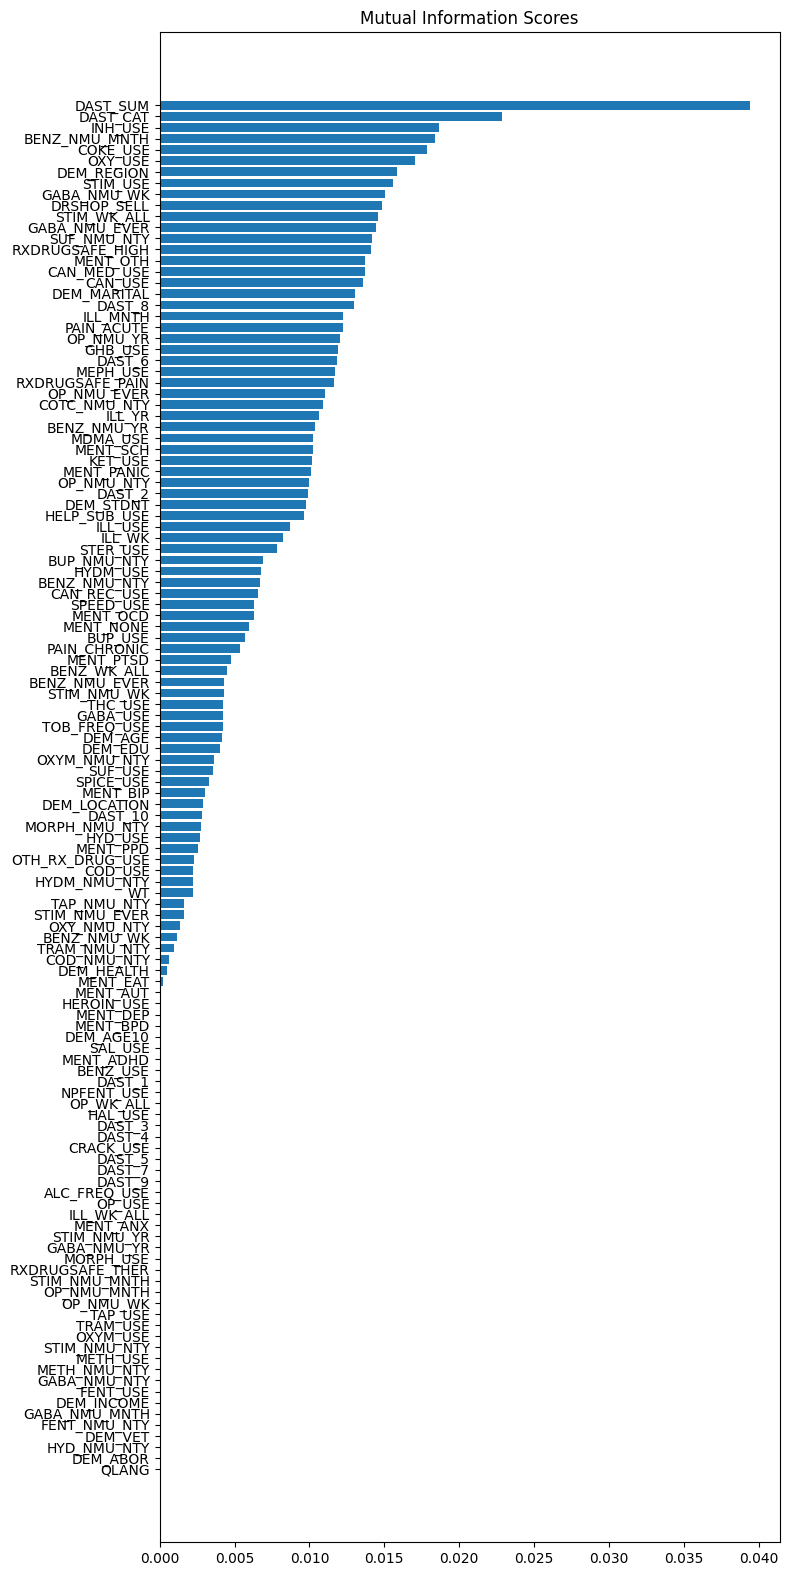

In [161]:
plt.figure(dpi=100, figsize=(8,20))
plot_mi_scores(mi_scores)

DAST_SUM = DAST-10 Score (0 to 10, 10 is most severe)  This is leaked information<br>
DAST_CAT = basically DAST-10 but categorical (5 levels) This is leaked information<br>
INH_USE = Inhalants (glue, gasolines, solvents, etc) (51) <br>
BENZ_NMU_MNTH - any benzodiazepine API last 30 day non-medical use (Z-drugs excluded) <br>
COKE_USE - Cocaine Powder (51) <br>
OXY_USE - Have you ever used Oxycodone (Oxy·IR®, OxyNEO®, Targin®, Percocet®, OxyContin®, Supeudol®, percs, OCs, oxy, oxy80, etc.)? (25) <br>
DEM_REGION - should be categorical (7) could be b/c WEST has way more provinces/territories
STIM_USE - Have you ever used a prescription stimulant (Adderall®, Elvanse®, Vyvanse®, Ritalin®, Concerta®, Strattera®, Dexedrine®, etc.)? This does NOT include store-bought, non-pharamaceutical, or over-the-counter stimulants (42) <br>
GABA_NMU_EVER, GABA_NMU_WK but no GABA_NMU_YR, MNTH, NTY <br>
DRSHOP_SELL - KIND OF A LEAK <br>
RXDRUGSAFE_HIGH - believe prescription drugs are safer than illicit drugs (to get high) (61)<br>
DEM_MARITAL - marital status (9)<br>
DAST_8 - have you done illegal activity to get drugs? (74)<br>
EVERY NMU is probably leaked information


In [17]:
#hide_output
# Train test split
X = df.drop(['DRSHOP_NMU'], axis=1)
y = df.DRSHOP_NMU

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, shuffle=True)
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

## Modelling section

For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data. [credit](https://medium.com/swlh/random-forest-classification-and-its-implementation-d5d840dbead0#:~:text=For%20data%20including%20categorical%20variables,for%20this%20type%20of%20data.)

## Citation
- https://medium.com/swlh/random-forest-classification-and-its-implementation-d5d840dbead0#:~:text=For%20data%20including%20categorical%20variables,for%20this%20type%20of%20data.